# Exploration Analysis

Experimenting with entropy-based exploration and "free" exploration in 1D.

In [106]:
import abc
import matplotlib.pyplot as plt
import numpy as np
from multitask_personalization.utils import Bounded1DClassifier, bernoulli_entropy

np.random.seed(1)

# Unknown parameters.
ground_truth_lb = 0.1
ground_truth_ub = 0.3

# Known parameters.
global_lb = 0.0
global_ub = 1.25

## Base Classes
An interface for predictive models and explorers (active learning).

In [107]:
class PredictiveModel(abc.ABC):
    """Learns and predicts."""

    @abc.abstractmethod
    def predict(self, inputs: list[float]) -> list[float]:
        """Predicts probability of true."""

    def classify(self, inputs: list[float]) -> list[bool]:
        """Predicts true or false."""
        predictions = self.predict(inputs)
        return [y >= 0.5 for y in predictions]

    @abc.abstractmethod
    def update(self, input: float, label: bool) -> None:
        """Update the model."""


class Explorer(abc.ABC):
    """The active learner."""

    def __init__(self, model: PredictiveModel, global_lb: float, global_ub: float,
                 seed: int = 1) -> None:
        self.model = model
        self.global_lb = global_lb
        self.global_ub = global_ub
        self.seed = seed
        self._rng = np.random.default_rng(seed)

    @abc.abstractmethod
    def get_next_request(self) -> float:
        """Get an input for labelling."""


## Predictive Models

In [108]:
class Bounded1DClassifierPredictiveModel(PredictiveModel):

    def __init__(self, a_lo: float, b_hi: float) -> None:
        self._classifier = Bounded1DClassifier(a_lo, b_hi)

    def predict(self, inputs: list[float]) -> list[float]:
        return self._classifier.predict_proba(inputs)
    
    def update(self, input: float, label: bool) -> None:
        return self._classifier.fit_incremental([input], [label])

## Explorers

In [109]:
class FreeExplorer(Explorer):

    def get_next_request(self) -> float:
        return self._rng.uniform(self.global_lb, self.global_ub)
    

class EntropyExplorer(Explorer):

    def __init__(self, *args, num_samples: int = 10, **kwargs):
        super().__init__(*args, **kwargs)
        self._num_samples = num_samples

    def get_next_request(self) -> float:
        samples = self._rng.uniform(self.global_lb, self.global_ub, size=self._num_samples)
        probas = self.model.predict(samples)
        scores = [bernoulli_entropy(np.log(p)) for p in probas]
        idx = np.argmax(scores)
        return samples[idx]

## Analysis

/var/folders/px/5p5ncg216n951x06wktc93xr0000gn/T/ipykernel_26169/290512507.py:16: RuntimeWarning: divide by zero encountered in log
  scores = [bernoulli_entropy(np.log(p)) for p in probas]


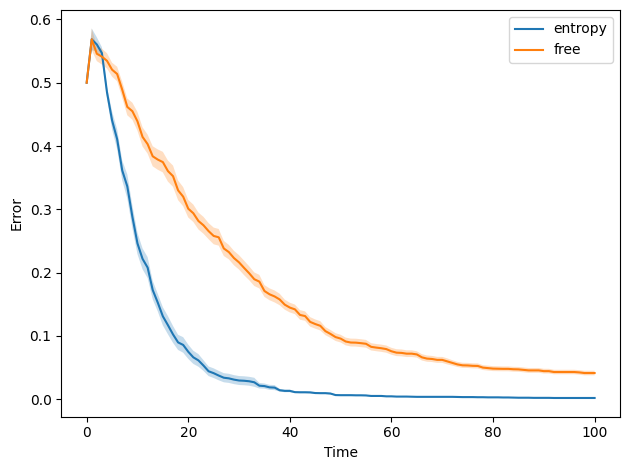

In [110]:
def generate_eval_data(ground_truth_model: PredictiveModel,
                       num_eval_points: int = 100,
                       seed: int = 1,
                       balance_data: bool = True) -> tuple[list[float], list[bool]]:
    rng = np.random.default_rng(seed)
    inputs = []
    labels = []
    while len(inputs) < num_eval_points:
        x = rng.uniform(global_lb, global_ub)
        label = ground_truth_model.classify([x])[0]
        if balance_data:
            if label and (sum(labels) >= num_eval_points // 2):
                continue
            if not label and (len(labels) - sum(labels) >= num_eval_points // 2):
                continue
            inputs.append(x)
            labels.append(label)
    return inputs, labels


def loss(model: PredictiveModel, eval_inputs: list[float], eval_outputs: list[bool]) -> float:
    assert len(eval_inputs) == len(eval_outputs)
    preds = model.predict(eval_inputs)
    assert len(preds) == len(eval_inputs)
    return np.sum(np.not_equal(preds, eval_outputs)) / len(eval_inputs)


def run_single_episode(explorer: Explorer, ground_truth_model: PredictiveModel,
                       num_steps: int = 100, num_eval_points: int = 100,
                       seed: int = 1) -> list[float]:
    eval_inputs, eval_outputs = generate_eval_data(ground_truth_model,
                                                   num_eval_points=num_eval_points,
                                                   seed=seed)
    errors = [loss(explorer.model, eval_inputs, eval_outputs)]
    for _ in range(num_steps):
        x = explorer.get_next_request()
        y = ground_truth_model.classify([x])[0]
        explorer.model.update(x, y)
        error = loss(explorer.model, eval_inputs, eval_outputs)
        errors.append(error)
    return errors


def run_all_experiments(explorer_names: list[str], num_trials: int = 10,
                        num_steps: int = 100) -> dict[str, list[list[float]]]:
    results : dict[str, list[list[float]]] = {name: [] for name in explorer_names}
    
    ground_truth_model = Bounded1DClassifierPredictiveModel(ground_truth_lb, ground_truth_ub)

    for trial in range(num_trials):
        seed = trial
        for explorer_name in explorer_names:
            model = Bounded1DClassifierPredictiveModel(global_lb, global_ub)
            if explorer_name == "free":
                explorer = FreeExplorer(model, global_lb, global_ub, seed=seed)
            elif explorer_name == "entropy":
                explorer = EntropyExplorer(model, global_lb, global_ub, seed=seed)
            else:
                raise NotImplementedError
            
            errors = run_single_episode(explorer, ground_truth_model, 
                                        num_steps=num_steps, seed=seed)
            results[explorer_name].append(errors)
    
    return results


def _main():
    explorer_names = ["entropy", "free"]
    num_steps = 100
    num_trials = 50
    results = run_all_experiments(explorer_names, num_trials=num_trials,
                                  num_steps=num_steps)

    plt.figure()
    for explorer_name, explorer_results in results.items():
        mean_results = np.mean(explorer_results, axis=0)
        std_results = np.std(explorer_results, axis=0, ddof=1) / np.sqrt(len(mean_results))
        assert len(mean_results) == num_steps + 1
        X = np.arange(num_steps+1)
        plt.plot(X, mean_results, label=explorer_name)
        plt.fill_between(X, mean_results - std_results, mean_results + std_results,
                         alpha=0.25)
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
_main()